<a href="https://colab.research.google.com/github/whbpt/SMURF/blob/main/examples/af_msa_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
if [ ! -d af_backprop ]; then
  git clone https://github.com/sokrypton/af_backprop.git
  pip -q install py3Dmol biopython ml_collections dm-haiku
fi
if [ ! -d SMURF ]; then
  git clone https://github.com/spetti/SMURF.git
fi
if [ ! -d params ]; then
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
fi

Cloning into 'af_backprop'...
Cloning into 'SMURF'...


In [ ]:
import os
import jax
import jax.numpy as jnp
from jax.experimental.optimizers import adam

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('af_backprop')
sys.path.append('SMURF')
from utils import *

import laxy
import sw_functions as sw
import network_functions as nf

# import libraries
from alphafold.common import protein
from alphafold.data import pipeline
from alphafold.model import data, config, model
from alphafold.data import parsers
from alphafold.model import all_atom

In [ ]:
def get_feat(filename, alphabet="ARNDCQEGHILKMFPSTWYV"):
  '''
  Given A3M file (from hhblits)
  return MSA (aligned), MS (unaligned) and ALN (alignment)
  '''
  def parse_fasta(filename):
    '''function to parse fasta file'''    
    header, sequence = [],[]
    lines = open(filename, "r")
    for line in lines:
      line = line.rstrip()
      if len(line) == 0: pass
      else:
        if line[0] == ">":
          header.append(line[1:])
          sequence.append([])
        else:
          sequence[-1].append(line)
    lines.close()
    sequence = [''.join(seq) for seq in sequence]
    return header, sequence

  names, seqs = parse_fasta(filename)  
  a2n = {a:n for n,a in enumerate(alphabet)}
  def get_seqref(x):
    n,seq,ref,aligned_seq = 0,[],[],[]
    for aa in list(x):
      if aa != "-":
        seq.append(a2n.get(aa.upper(),-1))
        if aa.islower(): ref.append(-1); n -= 1
        else: ref.append(n); aligned_seq.append(seq[-1])
      else: aligned_seq.append(-1)
      n += 1
    return seq, ref, aligned_seq
  
  # get the multiple sequence alignment
  max_len = 0
  ms, aln, msa = [],[],[]
  for seq in seqs:
    seq_,ref_,aligned_seq_ = get_seqref(seq)
    if len(seq_) > max_len: max_len = len(seq_)
    ms.append(seq_)
    msa.append(aligned_seq_)
    aln.append(ref_)
  
  return msa, ms, aln

In [ ]:
def prep_inputs(DOM):
  a3m_file = f"SMURF/examples/CASP_examples/{DOM}.mmseqs.id90cov75.a3m"
  _, ms, aln = get_feat(a3m_file)
  lens = np.asarray([len(m) for m in ms])
  ms = nf.one_hot(nf.pad_max(ms))
  aln = nf.one_hot(nf.pad_max(aln))
  N = len(ms)
  protein_obj = protein.from_pdb_string(pdb_to_string(f"SMURF/examples/CASP_examples/{DOM}.pdb"))
  batch = {'aatype': protein_obj.aatype,
          'all_atom_positions': protein_obj.atom_positions,
          'all_atom_mask': protein_obj.atom_mask}
  batch.update(all_atom.atom37_to_frames(**batch)) # for fape calculcation
  msa, mtx = parsers.parse_a3m(open(a3m_file,"r").read())
  feature_dict = {
      **pipeline.make_sequence_features(sequence=msa[0],description="none",num_res=len(msa[0])),
      **pipeline.make_msa_features(msas=[msa], deletion_matrices=[mtx])
  }
  feature_dict["residue_index"] = protein_obj.residue_index
  return {"N":N,"lens":lens,
          "ms":ms,"aln":aln,
          "feature_dict":feature_dict,
          "protein_obj":protein_obj, "batch":batch}

In [ ]:
def get_model_runner(num_seq, model_name="model_3_ptm", dropout=False, backprop_recycles=False):
  # setup which model params to use
  model_config = config.model_config(model_name)
  model_config.model.global_config.use_remat = True

  model_config.model.num_recycle = 3
  model_config.data.common.num_recycle = 3

  model_config.data.eval.max_msa_clusters = num_seq
  model_config.data.common.max_extra_msa = 1
  model_config.data.eval.masked_msa_replace_fraction = 0

  # backprop through recycles
  model_config.model.backprop_recycle = backprop_recycles
  model_config.model.embeddings_and_evoformer.backprop_dgram = backprop_recycles

  if not dropout:
    model_config = set_dropout(model_config,0)

  # setup model
  model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
  model_runner = model.RunModel(model_config, model_params, is_training=True)
  return model_runner, model_params

In [ ]:
def get_grad_fn(model_runner, x_ref_len, confidence=True, supervised=False, unsupervised=False, batch=None):
  def mod(msa_params, key, inputs, model_params, msa_inputs):  

    # get embedding per sequence
    emb = laxy.Conv1D(msa_params["emb"])(msa_inputs["x"])

    # get similarity matrix
    lengths = jnp.stack([msa_inputs["lengths"], jnp.broadcast_to(x_ref_len,msa_inputs["lengths"].shape)],-1)
    sm_mtx = emb @ emb[0,:x_ref_len].T
    sm_mask = jnp.broadcast_to(msa_inputs["x"].sum(-1,keepdims=True), sm_mtx.shape)
    sm_mtx = nf.norm_row_col(sm_mtx, sm_mask, norm_mode="fast")

    # get alignment
    aln = sw.sw()(sm_mtx, lengths, msa_params["gap"], 1.0)

    # get msa
    x_msa = jnp.einsum("...ia,...ij->...ja", msa_inputs["x"], aln)
    x_msa = x_msa.at[0,:,:].set(msa_inputs["x"][0,:x_ref_len,:])
    
    # add gap character
    x_gap = jax.nn.relu(1 - x_msa.sum(-1,keepdims=True))
    x_msa_gap = jnp.concatenate([x_msa,jnp.zeros_like(x_gap),x_gap],-1)

    # update msa
    inputs_mod = inputs
    inputs_mod["msa_feat"] = jnp.zeros_like(inputs["msa_feat"]).at[...,0:22].set(x_msa_gap).at[...,25:47].set(x_msa_gap)

    # get alphafold outputs
    outputs = model_runner.apply(model_params, key, inputs_mod)

    #################
    # compute loss
    #################
    # distance to correct solution
    rmsd_loss = jnp_rmsd(INPUTS["protein_obj"].atom_positions[:,1,:],
                         outputs["structure_module"]["final_atom_positions"][:,1,:])

    loss = 0
    losses = {"rmsd":rmsd_loss}
    if supervised:
      dgram_loss = get_dgram_loss(batch, outputs, model_config=model_runner.config)
      fape_loss = get_fape_loss(batch, outputs, model_config=model_runner.config)
      loss += dgram_loss + fape_loss
      losses.update({"dgram":dgram_loss, "fape":fape_loss})

    if unsupervised:
      x_msa_pred_logits = outputs["masked_msa"]["logits"]
      x_ms_pred_logits = jnp.einsum("...ja,...ij->...ia", x_msa_pred_logits, aln)
      x_ms_pred_log_softmax = jax.nn.log_softmax(x_ms_pred_logits[...,:22])[...,:20]
      cce_loss = -(msa_inputs["x"] * x_ms_pred_log_softmax).sum() / msa_inputs["x"].sum()
      loss += cce_loss
      losses.update({"cce":cce_loss})
      
    if confidence:
      pae_loss = jax.nn.softmax(outputs["predicted_aligned_error"]["logits"])
      pae_loss = (pae_loss * jnp.arange(pae_loss.shape[-1])).sum(-1).mean()
      plddt_loss = jax.nn.softmax(outputs["predicted_lddt"]["logits"])
      plddt_loss = (plddt_loss * jnp.arange(plddt_loss.shape[-1])[::-1]).sum(-1).mean()
      loss += pae_loss + plddt_loss
      losses.update({"pae":pae_loss, "plddt":plddt_loss})
      
    outs = {"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
            "final_atom_mask":outputs["structure_module"]["final_atom_mask"]}

    return loss, ({"plddt": get_plddt(outputs),
                   "losses":losses, "outputs":outs,                   
                   "msa":x_msa_gap, "seq":x_msa[0]})
  
  return mod, jax.value_and_grad(mod, has_aux=True, argnums=0)

In [ ]:
adv_loss = None
confidence = True
supervised = False 
unsupervised = False
dropout = False
backprop_recycles = False

# NOTE: the structure for T1070-D1 is not yet public, it will be added to github once released in the PDB.
for DOM in ["T1064-D1","T1038-D1","T1043-D1","T1039-D1"]: # "T1070-D1"]:
  # prep inputs
  INPUTS = prep_inputs(DOM)
  msa_inputs = {"x":INPUTS["ms"], "aln":INPUTS["aln"], "lengths":INPUTS["lens"]}
  
  # setup AlphaFold model
  model_runner, model_params = get_model_runner(INPUTS["N"], dropout=dropout,backprop_recycles=backprop_recycles)
  inputs = model_runner.process_features(INPUTS["feature_dict"], random_seed=0)
  loss_fn, grad_fn = get_grad_fn(model_runner, x_ref_len=INPUTS["lens"][0],
                                 confidence=confidence, unsupervised=unsupervised, supervised=supervised,
                                 batch=INPUTS["batch"]) 
  grad_fn = jax.jit(grad_fn)

  LOSSES = []
  # testing 6 MSA pretraining methods
  for mode in ["random"]: #,"ba","ba_sup","smurf","ba_smurf","ba_sup_smurf"]:
    # random = starting with random convolutions
    # ba = pretrain convolutions using basic-align
    # ba_sup = pretrain convolutions using basic-align to recreate the initial MSA
    # smurf = pretrain convolutions using smurf
    # ba_smurf = pretrain convolutions using smurf+basic-align
    # ba_sup_smurf = pretrain convolutions using smurf+basic-align

    suffix = f'{adv_loss}.{mode}'
    if supervised: suffix += "_supervised"
    if unsupervised: suffix += "_unsupervised"
    if backprop_recycles: suffix += "_backprop-recycles"

    npy_file = f"{DOM}.traj.{suffix}.npy"
    
    if not os.path.isfile(npy_file):
      BEST_PLDDT = 0
      losses = []
      for seed in range(30): # try different seeds and learning rates
        lr = [1e-2,1e-3,1e-4][seed%3]
        init_fun, update_fun, get_params = adam(step_size=lr) 
        def step(i, state, key, inputs, model_params, msa_inputs):
          (loss, outs), grad = grad_fn(get_params(state), key, inputs, model_params, msa_inputs)
          state = update_fun(i, grad, state)
          return state, (loss,outs)
        ######################################################
        key = jax.random.PRNGKey(seed)
        ###################################
        # pretrain w/ BasicAlign
        ###################################
        msa_inputs = {"x":INPUTS["ms"], "aln":INPUTS["aln"], "lengths":INPUTS["lens"]}
        if mode == "random":
          state = init_fun({"emb":laxy.Conv1D()(20,512,18,key=key),
                            "gap":jnp.full([],-3.0,dtype=jnp.float32)})
        if "ba" in mode:
          if "sup" in mode:
            msa_model = nf.BasicAlign(X=INPUTS["ms"],lengths=INPUTS["lens"],
                                      sw_open=None, sw_gap=-3.0, sw_learn_gap=True,
                                      seed=seed, batch_size=INPUTS["N"],
                                      supervise=True, nat_aln=INPUTS["aln"])
          else:
            msa_model = nf.BasicAlign(X=INPUTS["ms"],lengths=INPUTS["lens"],
                                      sw_open=None, sw_gap=-3.0, sw_learn_gap=True,
                                      seed=seed, batch_size=INPUTS["N"])
        if "smurf" in mode:
          smurf_model = nf.MRF(X=INPUTS["ms"], lengths=INPUTS["lens"], batch_size=INPUTS["N"],
                              sw_open=None, sw_gap=-3.0, sw_learn_gap=True, seed=seed)
          if "ba" in mode:
            _ = msa_model.fit(2000, verbose=False)
            msa_params = msa_model.opt.get_params()

            smurf_params = smurf_model.opt.get_params()
            smurf_params.update({k:msa_params[k] for k in ["emb","gap","open"]})
            smurf_model.opt.set_params(smurf_params)

          _ = smurf_model.fit(2000, verbose=False)
          smurf_params = smurf_model.opt.get_params()
          state = init_fun({"emb":smurf_params["emb"],"gap":smurf_params["gap"]})    

        elif "ba" in mode:
          _ = msa_model.fit(4000, verbose=False)
          msa_params = msa_model.opt.get_params()
          state = init_fun({"emb":msa_params["emb"],"gap":msa_params["gap"]})    

        # optimize!
        losses.append([])
        for i in range(100):
          key,subkey = jax.random.split(key)
          state, (loss,outs) = step(i, state, subkey, inputs, model_params, msa_inputs)
          plddt = outs["plddt"].mean()
          # save results
          losses[-1].append([loss,plddt])
          losses[-1][-1].append(outs["losses"]["rmsd"])
          if unsupervised: losses[-1][-1].append(outs["losses"]["cce"])
            
          print(DOM, seed, i, *losses[-1][-1])
          if plddt > BEST_PLDDT:
            BEST_PLDDT = plddt
            save_pdb(outs,f"{DOM}.{suffix}.pred.pdb")
                    
      np.save(npy_file, losses)
    else:
      losses = np.load(npy_file)
      
    LOSSES.append(losses) 

In [ ]:
DOMS = ["T1070-D1","T1039-D1","T1038-D1","T1043-D1","T1064-D1"]
VALS = [[0.627021797996172,7.9085627],[0.522569996053579,9.804814],
        [0.725891903100609,8.154645],[0.361457601819099,17.92791],
        [0.354278629507625,13.859991]]
vals = {d:v for d,v in zip(DOMS,VALS)}

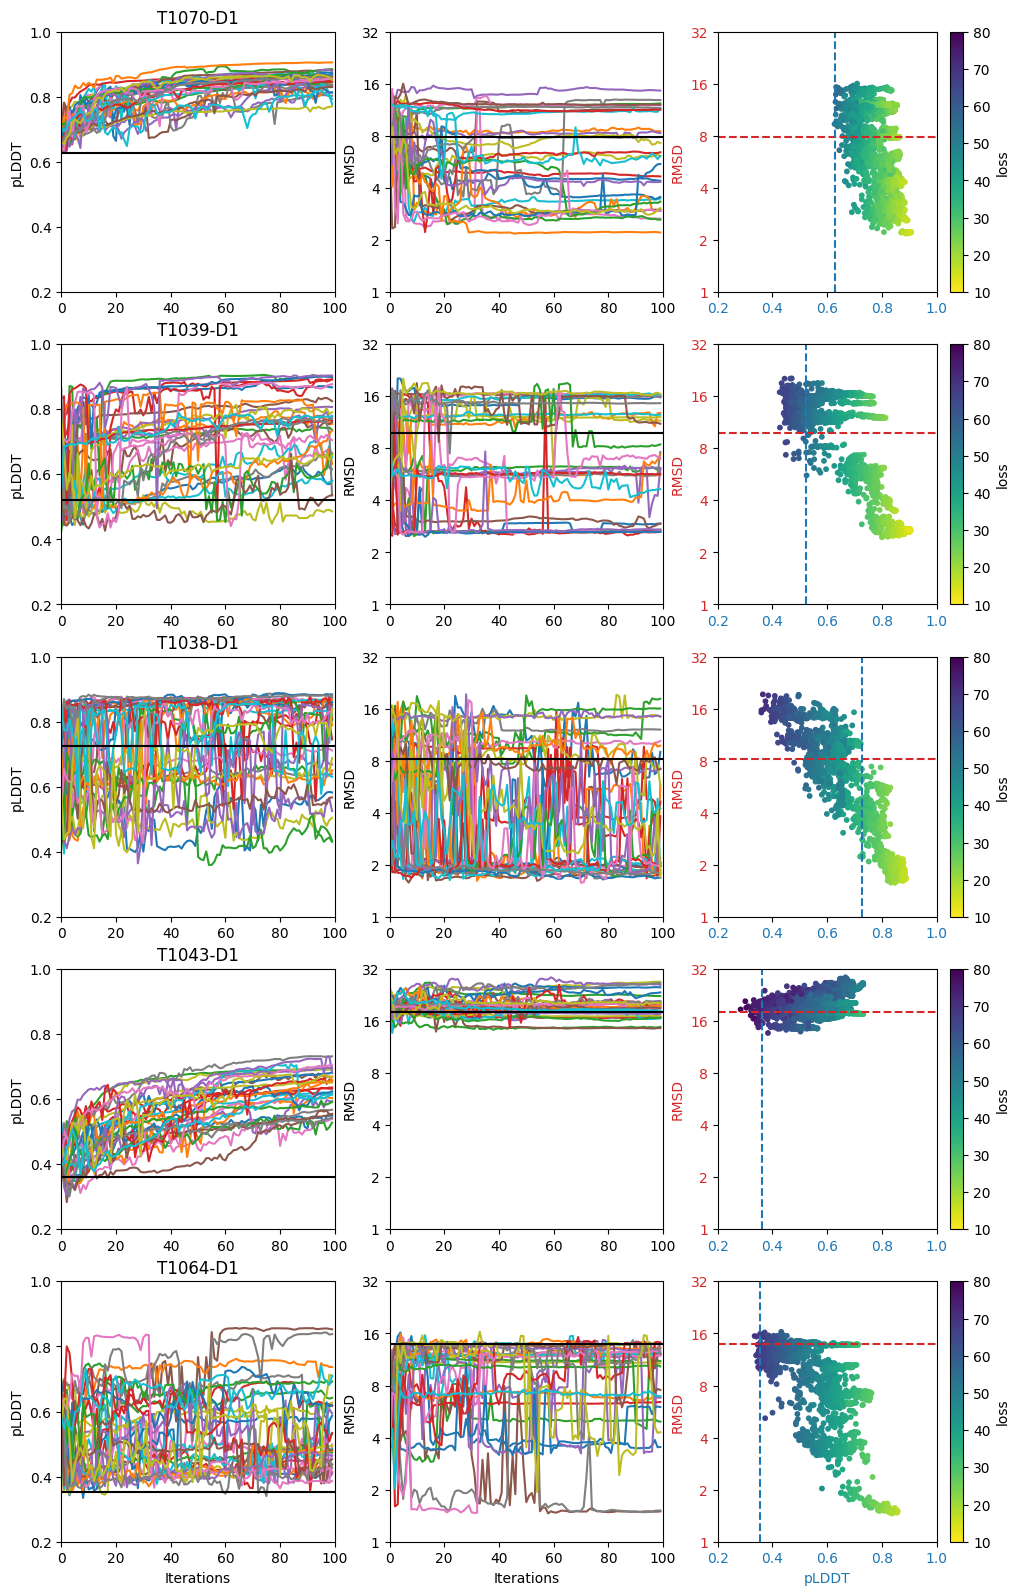

In [ ]:
mode = "random"
plt.figure(figsize=(12,4*5),dpi=100)
k = 1
for DOM in ["T1039-D1","T1038-D1","T1043-D1","T1064-D1"]: #,"T1070-D1"]
  npy_file = f"{DOM}.traj.{adv_loss}.{mode}.npy"
  if os.path.isfile(npy_file):
    losses = np.load(npy_file)
    plt.subplot(5,3,k)
    plt.title(f"{DOM}")

    plt.plot(losses[:,:,1].T)
    if k in [13]: plt.xlabel("Iterations");
    if k in [1,4,7,1+9,4+9,7+9]: plt.ylabel("pLDDT")
    plt.ylim(0.2,1.0)
    plt.xlim(0,100)
    plt.yticks([0.2,0.4,0.6,0.8,1.0],[0.2,0.4,0.6,0.8,1.0])
    plt.plot([0,100],[vals[DOM][0],vals[DOM][0]],color="black")
    k += 1

    plt.subplot(5,3,k)
    plt.plot(losses[:,:,2].T)
    if k in [14]: plt.xlabel("Iterations")
    plt.ylabel("RMSD")
    plt.ylim(1,32)
    plt.xlim(0,100)
    plt.yscale("log",base=2);plt.yticks([1,2,4,8,16,32],[1,2,4,8,16,32])
    plt.plot([0,100],[vals[DOM][1],vals[DOM][1]],color="black")
    k += 1

    plt.subplot(5,3,k)
    plt.scatter(losses[:,:,1], # plddt
                losses[:,:,2], # rmsd
                c=losses[:,:,0], # loss
                vmin=10, vmax=80,s=10, cmap="viridis_r")

    plt.yscale("log",base=2,)
    plt.yticks([1,2,4,8,16,32],[1,2,4,8,16,32],color="tab:red")
    plt.ylim(1,32)
    plt.ylabel("RMSD",color="tab:red")

    if k in [15]: plt.xlabel("pLDDT",color="tab:blue")
    plt.xlim(0.2,1.0)
    plt.xticks([0.2,0.4,0.6,0.8,1.0],[0.2,0.4,0.6,0.8,1.0],color="tab:blue")

    plt.plot([0.2,1],[vals[DOM][1],vals[DOM][1]],"--",color="tab:red")
    plt.plot([vals[DOM][0],vals[DOM][0]],[1,32],"--",color="tab:blue")

    plt.colorbar(label="loss")
    k += 1

plt.savefig(f"ALL.{adv_loss}.{mode}.pdf",bbox_inches='tight')
plt.show()